In [3]:
#Funkcja modelująca rozkład temperatury w 1D 
import numpy as np
def solve_temperature_1D(T_left, T_right, N=50, kal=237.0, kw=0.12, tolerance=0.01):
    """
    Rozwiązuje jednowymiarowy, stacjonarny problem przewodnictwa ciepła
    dla niejednorodnego pręta z dwoma różnymi materiałami.

    Parametry:
    - T_left: temperatura na lewym brzegu pręta
    - T_right: temperatura na prawym brzegu pręta
    - N: liczba węzłów w siatce
    - kal: współczynnik przewodnictwa cieplnego (aluminium)
    - kw: współczynnik przewodnictwa cieplnego (drewno)
    - tolerance: kryterium zbieżności iteracji

    Zwraca:
    - T: rozkład temperatury w pręcie
    """
    dx = 1.0 / (N - 1)

    # Inicjalizacja temperatury
    T = np.zeros(N)
    T[0] = T_left
    T[-1] = T_right

    # Inicjalizacja współczynników przewodnictwa cieplnego
    k = np.ones(N) * kal
    k[N//2:] = kw  # Połowa pręta z drewna

    # Iteracyjne rozwiązywanie równania różnicowego
    for _ in range(10000):
        T_old = T.copy()
        for i in range(1, N - 1):
            T[i] = (k[i-1] * T_old[i-1] + k[i] * T_old[i+1]) / (k[i-1] + k[i])

        # Kryterium zbieżności
        if np.linalg.norm(T - T_old, np.inf) < tolerance:
            break

    return T



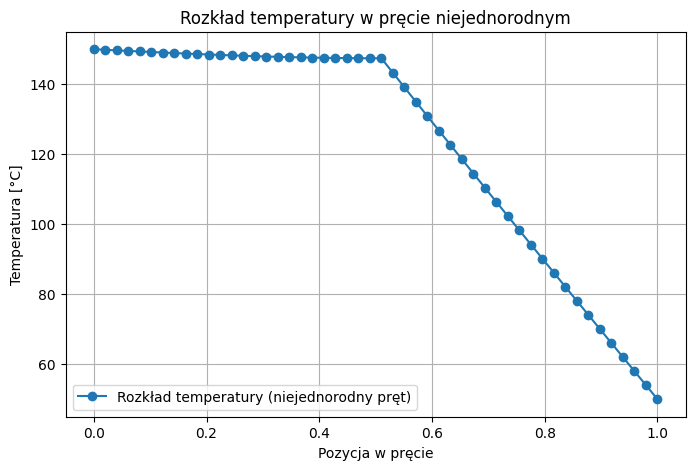

In [ ]:
#Test
import matplotlib.pyplot as plt

# Parametry testowe
N = 50
T0 = 150     # Temperatura na lewym brzegu
TN = 50      # Temperatura na prawym brzegu
kal = 237.0  # Przewodność cieplna aluminium
kw = 0.12    # Przewodność cieplna drewna

# Testowanie funkcji z uwzględnieniem niejednorodności
T_test = solve_temperature_1D(T0, TN, N, kal, kw)

# Wizualizacja wyników
plt.figure(figsize=(8, 5))
plt.plot(np.linspace(0, 1, N), T_test, '-o', label='Rozkład temperatury (niejednorodny pręt)')
plt.title('Rozkład temperatury w pręcie niejednorodnym')
plt.xlabel('Pozycja w pręcie')
plt.ylabel('Temperatura [°C]')
plt.grid(True)
plt.legend()
plt.show()


In [16]:
#Funkcja kosztu
def cost_function_1D(boundary_conditions, T_target, N=50, kal=237.0, kw=0.12):
    """
    Funkcja kosztu dla modelu 1D - mierzy różnicę między obliczonym a docelowym rozkładem temperatury.

    Parametry:
    - boundary_conditions: lista [T_left, T_right] - warunki brzegowe
    - T_target: docelowy rozkład temperatury
    - N: liczba węzłów w siatce
    - kal: współczynnik przewodnictwa cieplnego (aluminium)
    - kw: współczynnik przewodnictwa cieplnego (drewno)

    Zwraca:
    - Wartość funkcji kosztu (norma L2)
    """
    T_left, T_right = boundary_conditions
    T_model = solve_temperature_1D(T_left, T_right, N, kal, kw)
    
    # Norma L2 (średniokwadratowy błąd)
    return np.linalg.norm(T_model - T_target, 2)


In [26]:
#Testowanie funkcji kosztu
# Generowanie docelowego rozkładu temperatury (poprawne warunki brzegowe)
T_target = solve_temperature_1D(T0, TN, N, kal, kw)

# Test funkcji kosztu
test_conditions = [140, 60]  # Przykładowe warunki brzegowe (nieoptymalne)
cost_value = cost_function_1D(test_conditions, T_target, N, kal, kw)

print(f"Wartość funkcji kosztu dla warunków {test_conditions}: {cost_value:.4f}")



Wartość funkcji kosztu dla warunków [140, 60]: 58.2880


Implementacja metody BFGS

In [17]:
from scipy.optimize import minimize

def optimize_bfgs_1D(T_target, N=50, kal=237.0, kw=0.12):
    """
    Optymalizacja warunków brzegowych za pomocą metody BFGS dla modelu 1D.

    Parametry:
    - T_target: docelowy rozkład temperatury
    - N: liczba węzłów w siatce
    - kal: współczynnik przewodnictwa cieplnego (aluminium)
    - kw: współczynnik przewodnictwa cieplnego (drewno)

    Zwraca:
    - Wynik optymalizacji (optymalne warunki brzegowe)
    """
    # Inicjalne zgadywanie warunków brzegowych
    initial_guess = [100, 100]

    # Minimalizacja funkcji kosztu metodą BFGS
    result = minimize(cost_function_1D, 
                      initial_guess, 
                      args=(T_target, N, kal, kw), 
                      method='BFGS', 
                      options={'disp': True})
    
    return result.x  # Zwróć optymalne warunki brzegowe


c:\Users\msigm\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minimize.py:733: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.000000
         Iterations: 33
         Function evaluations: 320
         Gradient evaluations: 103
Optymalne warunki brzegowe (BFGS): [150.  50.]
Czas działania metody BFGS: 93.1221 s


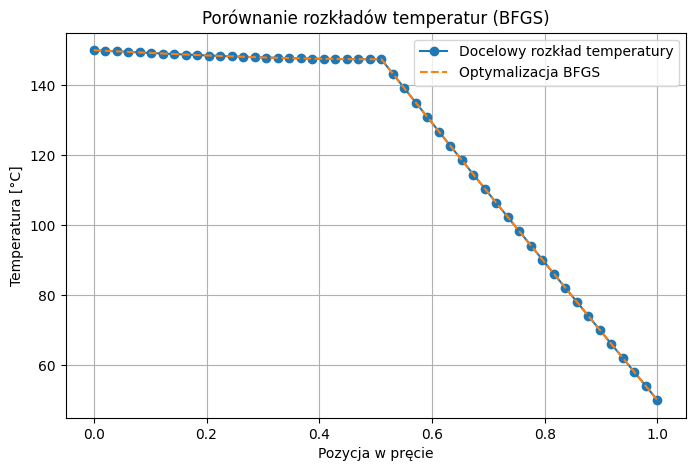


--- Podsumowanie wyników ---
Parametry testowe:
- Liczba węzłów (N): 50
- Przewodność cieplna aluminium (kal): 237.0
- Przewodność cieplna drewna (kw): 0.12
- Temperatura na lewym brzegu (T0): 150
- Temperatura na prawym brzegu (TN): 50
- Tolerancja: 0.01
- Maksymalna liczba iteracji: 10000

Uzyskane warunki brzegowe:
  T_left = 150.0000
  T_right = 50.0000
Czas trwania obliczeń: 93.1221 s


In [18]:
import time

# Parametry testowe
N = 50
kal = 237.0  # Przewodność cieplna aluminium
kw = 0.12    # Przewodność cieplna drewna
T0 = 150      # Temperatura na lewym brzegu
TN = 50       # Temperatura na prawym brzegu
tolerance = 0.01
max_iter = 10000

# Generowanie docelowego rozkładu temperatury (z uwzględnieniem kal i kw)
T_target = solve_temperature_1D(T0, TN, N, kal, kw)

# Pomiar czasu działania metody BFGS
start_time = time.time()
optimal_conditions_bfgs = optimize_bfgs_1D(T_target, N, kal, kw)
end_time = time.time()

# Wyniki
print(f"Optymalne warunki brzegowe (BFGS): {optimal_conditions_bfgs}")
print(f"Czas działania metody BFGS: {end_time - start_time:.4f} s")

# Wizualizacja wyników
T_optimized = solve_temperature_1D(optimal_conditions_bfgs[0], 
                                   optimal_conditions_bfgs[1], 
                                   N, kal, kw)

plt.figure(figsize=(8, 5))
plt.plot(np.linspace(0, 1, N), T_target, '-o', label='Docelowy rozkład temperatury')
plt.plot(np.linspace(0, 1, N), T_optimized, '--', label='Optymalizacja BFGS')
plt.title('Porównanie rozkładów temperatur (BFGS)')
plt.xlabel('Pozycja w pręcie')
plt.ylabel('Temperatura [°C]')
plt.grid(True)
plt.legend()
plt.show()

# Dokumentacja wyników
print("\n--- Podsumowanie wyników ---")
print("Parametry testowe:")
print(f"- Liczba węzłów (N): {N}")
print(f"- Przewodność cieplna aluminium (kal): {kal}")
print(f"- Przewodność cieplna drewna (kw): {kw}")
print(f"- Temperatura na lewym brzegu (T0): {T0}")
print(f"- Temperatura na prawym brzegu (TN): {TN}")
print(f"- Tolerancja: {tolerance}")
print(f"- Maksymalna liczba iteracji: {max_iter}")
print("\nUzyskane warunki brzegowe:")
print(f"  T_left = {optimal_conditions_bfgs[0]:.4f}")
print(f"  T_right = {optimal_conditions_bfgs[1]:.4f}")
print(f"Czas trwania obliczeń: {end_time - start_time:.4f} s")


Implementacja metody L-BFGS-B

In [19]:
from scipy.optimize import minimize

def optimize_lbfgsb_1D(T_target, N=50, kal=237.0, kw=0.12):
    """
    Optymalizacja warunków brzegowych za pomocą metody L-BFGS-B dla modelu 1D.

    Parametry:
    - T_target: docelowy rozkład temperatury
    - N: liczba węzłów w siatce
    - kal: współczynnik przewodnictwa cieplnego (aluminium)
    - kw: współczynnik przewodnictwa cieplnego (drewno)

    Zwraca:
    - Wynik optymalizacji (optymalne warunki brzegowe)
    """
    # Inicjalne zgadywanie warunków brzegowych
    initial_guess = [100, 100]

    # Ograniczenia dla warunków brzegowych (np. wartości dodatnie)
    bounds = [(0, 300), (0, 300)]

    # Minimalizacja funkcji kosztu metodą L-BFGS-B
    result = minimize(cost_function_1D, 
                      initial_guess, 
                      args=(T_target, N, kal, kw), 
                      method='L-BFGS-B', 
                      bounds=bounds,
                      options={'disp': True})

    return result.x  # Zwróć optymalne warunki brzegowe


Optymalne warunki brzegowe (L-BFGS-B): [150.  50.]
Czas działania metody L-BFGS-B: 66.2582 s


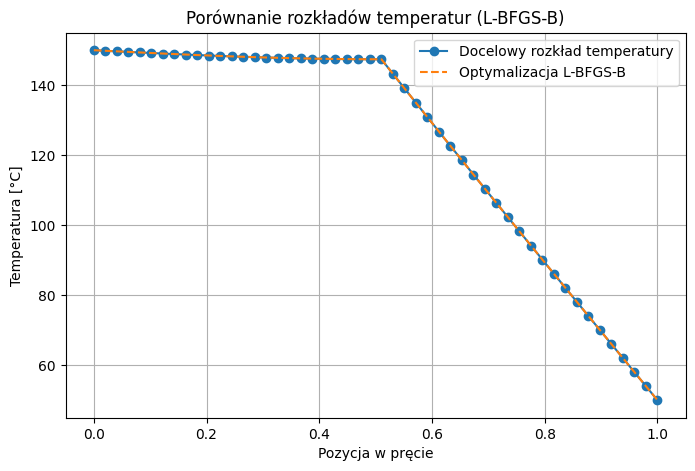


--- Podsumowanie wyników ---
Parametry testowe:
- Liczba węzłów (N): 50
- Przewodność cieplna aluminium (kal): 237.0
- Przewodność cieplna drewna (kw): 0.12
- Temperatura na lewym brzegu (T0): 150
- Temperatura na prawym brzegu (TN): 50
- Tolerancja: 0.01
- Maksymalna liczba iteracji: 10000

Uzyskane warunki brzegowe:
  T_left = 150.0000
  T_right = 50.0000
Czas trwania obliczeń: 66.2582 s


In [30]:
import time

# Generowanie docelowego rozkładu temperatury
T_target = solve_temperature_1D(T0, TN, N, kal, kw)

# Pomiar czasu działania metody L-BFGS-B
start_time = time.time()
optimal_conditions_lbfgsb = optimize_lbfgsb_1D(T_target, N, kal, kw)
end_time = time.time()

# Wyniki
print(f"Optymalne warunki brzegowe (L-BFGS-B): {optimal_conditions_lbfgsb}")
print(f"Czas działania metody L-BFGS-B: {end_time - start_time:.4f} s")

# Wizualizacja wyników
T_optimized = solve_temperature_1D(optimal_conditions_lbfgsb[0], 
                                   optimal_conditions_lbfgsb[1], 
                                   N, kal, kw)

plt.figure(figsize=(8, 5))
plt.plot(np.linspace(0, 1, N), T_target, '-o', label='Docelowy rozkład temperatury')
plt.plot(np.linspace(0, 1, N), T_optimized, '--', label='Optymalizacja L-BFGS-B')
plt.title('Porównanie rozkładów temperatur (L-BFGS-B)')
plt.xlabel('Pozycja w pręcie')
plt.ylabel('Temperatura [°C]')
plt.grid(True)
plt.legend()
plt.show()

# Dokumentacja wyników
print("\n--- Podsumowanie wyników ---")
print("Parametry testowe:")
print(f"- Liczba węzłów (N): {N}")
print(f"- Przewodność cieplna aluminium (kal): {kal}")
print(f"- Przewodność cieplna drewna (kw): {kw}")
print(f"- Temperatura na lewym brzegu (T0): {T0}")
print(f"- Temperatura na prawym brzegu (TN): {TN}")
print(f"- Tolerancja: {tolerance}")
print(f"- Maksymalna liczba iteracji: {max_iter}")
print("\nUzyskane warunki brzegowe:")
print(f"  T_left = {optimal_conditions_lbfgsb[0]:.4f}")
print(f"  T_right = {optimal_conditions_lbfgsb[1]:.4f}")
print(f"Czas trwania obliczeń: {end_time - start_time:.4f} s")


Implementacja metody Newton-CG.

In [20]:
def gradient_cost_function_1D(boundary_conditions, T_target, N=50, kal=237.0, kw=0.12):
    """
    Gradient funkcji kosztu dla modelu 1D.

    Parametry:
    - boundary_conditions: lista [T_left, T_right] - warunki brzegowe
    - T_target: docelowy rozkład temperatury
    - N: liczba węzłów w siatce
    - kal: współczynnik przewodnictwa cieplnego (aluminium)
    - kw: współczynnik przewodnictwa cieplnego (drewno)

    Zwraca:
    - Gradient funkcji kosztu
    """
    epsilon = 1e-5  # Mała wartość do aproksymacji numerycznej

    # Aproksymacja pochodnej względem T_left
    T_left, T_right = boundary_conditions
    grad_T_left = (cost_function_1D([T_left + epsilon, T_right], T_target, N, kal, kw) -
                   cost_function_1D([T_left - epsilon, T_right], T_target, N, kal, kw)) / (2 * epsilon)

    # Aproksymacja pochodnej względem T_right
    grad_T_right = (cost_function_1D([T_left, T_right + epsilon], T_target, N, kal, kw) -
                    cost_function_1D([T_left, T_right - epsilon], T_target, N, kal, kw)) / (2 * epsilon)

    return np.array([grad_T_left, grad_T_right])


In [21]:
from scipy.optimize import minimize

def optimize_newton_cg_1D(T_target, N=50, kal=237.0, kw=0.12):
    """
    Optymalizacja warunków brzegowych za pomocą metody Newton-CG dla modelu 1D.

    Parametry:
    - T_target: docelowy rozkład temperatury
    - N: liczba węzłów w siatce
    - kal: współczynnik przewodnictwa cieplnego (aluminium)
    - kw: współczynnik przewodnictwa cieplnego (drewno)

    Zwraca:
    - Wynik optymalizacji (optymalne warunki brzegowe)
    """
    # Inicjalne zgadywanie warunków brzegowych
    initial_guess = [100, 100]

    # Minimalizacja funkcji kosztu metodą Newton-CG
    result = minimize(cost_function_1D, 
                      initial_guess, 
                      args=(T_target, N, kal, kw), 
                      method='Newton-CG',
                      jac=gradient_cost_function_1D,
                      options={'disp': True})

    return result.x  # Zwróć optymalne warunki brzegowe


In [22]:
import time

# Generowanie docelowego rozkładu temperatury
T_target = solve_temperature_1D(T0, TN, N, kal, kw)

# Pomiar czasu działania metody Newton-CG
start_time = time.time()
optimal_conditions_newton_cg = optimize_newton_cg_1D(T_target, N, kal, kw)
end_time = time.time()

# Wyniki
print(f"Optymalne warunki brzegowe (Newton-CG): {optimal_conditions_newton_cg}")
print(f"Czas działania metody Newton-CG: {end_time - start_time:.4f} s")

# Wizualizacja wyników
T_optimized = solve_temperature_1D(optimal_conditions_newton_cg[0], 
                                   optimal_conditions_newton_cg[1], 
                                   N, kal, kw)

plt.figure(figsize=(8, 5))
plt.plot(np.linspace(0, 1, N), T_target, '-o', label='Docelowy rozkład temperatury')
plt.plot(np.linspace(0, 1, N), T_optimized, '--', label='Optymalizacja Newton-CG')
plt.title('Porównanie rozkładów temperatur (Newton-CG)')
plt.xlabel('Pozycja w pręcie')
plt.ylabel('Temperatura [°C]')
plt.grid(True)
plt.legend()
plt.show()

# Dokumentacja wyników
print("\n--- Podsumowanie wyników ---")
print("Parametry testowe:")
print(f"- Liczba węzłów (N): {N}")
print(f"- Przewodność cieplna aluminium (kal): {kal}")
print(f"- Przewodność cieplna drewna (kw): {kw}")
print(f"- Temperatura na lewym brzegu (T0): {T0}")
print(f"- Temperatura na prawym brzegu (TN): {TN}")
print(f"- Tolerancja: {tolerance}")
print(f"- Maksymalna liczba iteracji: {max_iter}")
print("\nUzyskane warunki brzegowe:")
print(f"  T_left = {optimal_conditions_newton_cg[0]:.4f}")
print(f"  T_right = {optimal_conditions_newton_cg[1]:.4f}")
print(f"Czas trwania obliczeń: {end_time - start_time:.4f} s")


KeyboardInterrupt: 

Implementacja metody Gradientu Prostego

In [11]:
from tqdm import tqdm  # Pasek postępu

def gradient_descent_1D(T_target, N=50, kal=237.0, kw=0.12, 
                        learning_rate=0.01, max_iter=10000, tolerance=0.01):
    """
    Optymalizacja warunków brzegowych metodą Gradientu Prostego (Gradient Descent)
    z dodaniem paska postępu.

    Parametry:
    - T_target: docelowy rozkład temperatury
    - N: liczba węzłów w siatce
    - kal: współczynnik przewodnictwa cieplnego (aluminium)
    - kw: współczynnik przewodnictwa cieplnego (drewno)
    - learning_rate: współczynnik uczenia (krok gradientowy)
    - max_iter: maksymalna liczba iteracji
    - tolerance: kryterium zakończenia (minimalny błąd)

    Zwraca:
    - Optymalne warunki brzegowe
    """
    # Inicjalne zgadywanie warunków brzegowych
    T_left, T_right = 100, 100

    for iteration in tqdm(range(max_iter), desc="Gradient Descent Progress", unit="iter"):
        # Obliczenie gradientu
        grad = gradient_cost_function_1D([T_left, T_right], T_target, N, kal, kw)
        
        # Aktualizacja warunków brzegowych zgodnie z kierunkiem gradientu
        T_left -= learning_rate * grad[0]
        T_right -= learning_rate * grad[1]

        # Kryterium stopu (jeśli gradient jest wystarczająco mały)
        if np.linalg.norm(grad) < tolerance:
            print(f"\n Konwergencja osiągnięta po {iteration + 1} iteracjach.")
            break

    return np.array([T_left, T_right])


In [24]:
import time

# Generowanie docelowego rozkładu temperatury
T_target = solve_temperature_1D(T0, TN, N, kal, kw)

# Pomiar czasu działania metody Gradientu Prostego
start_time = time.time()
optimal_conditions_gd = gradient_descent_1D(T_target, N, kal, kw)
end_time = time.time()

# Wyniki
print(f"Optymalne warunki brzegowe (Gradient Prostego): {optimal_conditions_gd}")
print(f"Czas działania metody Gradientu Prostego: {end_time - start_time:.4f} s")

# Wizualizacja wyników
T_optimized = solve_temperature_1D(optimal_conditions_gd[0], 
                                   optimal_conditions_gd[1], 
                                   N, kal, kw)

plt.figure(figsize=(8, 5))
plt.plot(np.linspace(0, 1, N), T_target, '-o', label='Docelowy rozkład temperatury')
plt.plot(np.linspace(0, 1, N), T_optimized, '--', label='Optymalizacja Gradient Prostego')
plt.title('Porównanie rozkładów temperatur (Gradient Prostego)')
plt.xlabel('Pozycja w pręcie')
plt.ylabel('Temperatura [°C]')
plt.grid(True)
plt.legend()
plt.show()

# Dokumentacja wyników
print("\n--- Podsumowanie wyników ---")
print("Parametry testowe:")
print(f"- Liczba węzłów (N): {N}")
print(f"- Przewodność cieplna aluminium (kal): {kal}")
print(f"- Przewodność cieplna drewna (kw): {kw}")
print(f"- Temperatura na lewym brzegu (T0): {T0}")
print(f"- Temperatura na prawym brzegu (TN): {TN}")
print(f"- Tolerancja: {tolerance}")
print(f"- Maksymalna liczba iteracji: {max_iter}")
print("\nUzyskane warunki brzegowe:")
print(f"  T_left = {optimal_conditions_gd[0]:.4f}")
print(f"  T_right = {optimal_conditions_gd[1]:.4f}")
print(f"Czas trwania obliczeń: {end_time - start_time:.4f} s")


Gradient Descent Progress:   0%|          | 2/10000 [00:10<15:01:21,  5.41s/iter]


KeyboardInterrupt: 

ZADANIA

Zadanie 1

c:\Users\msigm\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minimize.py:733: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.000000
         Iterations: 39
         Function evaluations: 360
         Gradient evaluations: 117


c:\Users\msigm\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minimize.py:733: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.000000
         Iterations: 34
         Function evaluations: 251
         Gradient evaluations: 80


c:\Users\msigm\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minimize.py:733: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.000000
         Iterations: 31
         Function evaluations: 219
         Gradient evaluations: 69


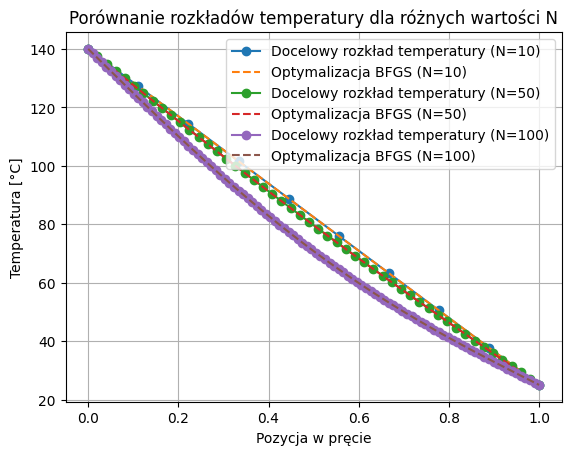

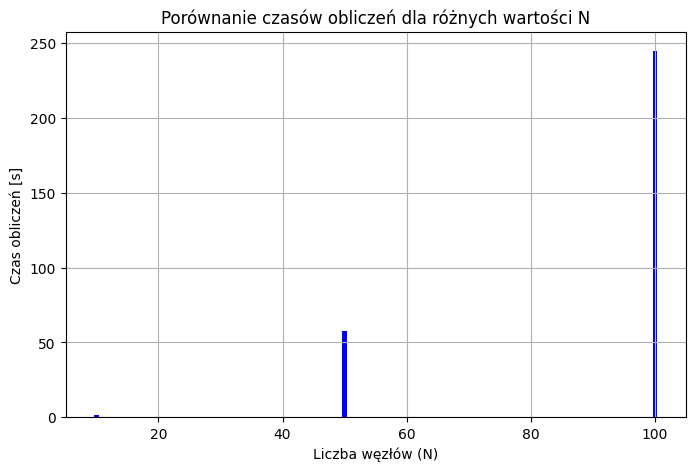

,N,Optymalne warunki brzegowe,Czas obliczeń [s],Błąd (norma L2)
0,10,"[139.99999999488222, 25.000000001597254]",1.608167,8.767737e-09
1,50,"[140.00000000309797, 24.999999996549345]",57.725390,1.369187e-08
2,100,"[139.9999999949538, 24.999999995761566]",245.201452,4.238942e-08


In [23]:
import time
import matplotlib.pyplot as plt

# Parametry testowe
kal = 237.0  # Przewodność cieplna aluminium (jednorodny materiał)
kw = 237.0    # Jednorodny materiał (przyjęty taki sam jak kal)
T_left = 140
T_right = 25
tolerance = 0.01
max_iter = 10000

# Lista wartości N do analizy
N_values = [10, 50, 100]

# Przechowywanie wyników
results = []

# Testowanie dla różnych wartości N
for N in N_values:
    # Generowanie docelowego rozkładu temperatury
    T_target = solve_temperature_1D(T_left, T_right, N, kal, kw)

    # Pomiar czasu działania metody BFGS
    start_time = time.time()
    optimal_conditions_bfgs = optimize_bfgs_1D(T_target, N, kal, kw)
    end_time = time.time()

    # Rozkład temperatury po optymalizacji
    T_optimized = solve_temperature_1D(optimal_conditions_bfgs[0], 
                                       optimal_conditions_bfgs[1], 
                                       N, kal, kw)
    
    # Obliczenie błędu (norma L2)
    error = np.linalg.norm(T_optimized - T_target, 2)

    # Przechowywanie wyników
    results.append({
        'N': N,
        'Optymalne warunki brzegowe': optimal_conditions_bfgs,
        'Czas obliczeń [s]': end_time - start_time,
        'Błąd (norma L2)': error
    })

    # Wizualizacja rozkładu temperatury
    plt.plot(np.linspace(0, 1, N), T_target, '-o', label=f'Docelowy rozkład temperatury (N={N})')
    plt.plot(np.linspace(0, 1, N), T_optimized, '--', label=f'Optymalizacja BFGS (N={N})')

# Finalizacja wykresu rozkładu temperatury
plt.title('Porównanie rozkładów temperatury dla różnych wartości N')
plt.xlabel('Pozycja w pręcie')
plt.ylabel('Temperatura [°C]')
plt.grid(True)
plt.legend()
plt.show()

# Tabela wyników
import pandas as pd
df_results = pd.DataFrame(results)

# Wizualizacja czasów obliczeń
plt.figure(figsize=(8, 5))
plt.bar(df_results['N'], df_results['Czas obliczeń [s]'], color='blue')
plt.title('Porównanie czasów obliczeń dla różnych wartości N')
plt.xlabel('Liczba węzłów (N)')
plt.ylabel('Czas obliczeń [s]')
plt.grid(True)
plt.show()

# Wyświetlenie wyników
display(df_results)


Przeprowadzona analiza pozwoliła zbadać, jak liczba węzłów (N) wpływa na dokładność rozwiązania oraz czas obliczeń w zadaniu odwrotnym dotyczącym jednorodnego pręta w stanie stacjonarnym. W trakcie eksperymentu porównano wyniki dla trzech różnych wartości N: 10, 50 i 100.

Wyniki pokazują, że zwiększenie liczby węzłów nie przynosi istotnej poprawy dokładności. Już przy N = 10 uzyskano bardzo precyzyjne odwzorowanie docelowego rozkładu temperatury. Błąd obliczeń (norma L2) pozostawał na poziomie rzędu 10⁻⁸, co oznacza, że różnice między rozkładem symulowanym a docelowym były minimalne. Dalsze zwiększanie liczby węzłów prowadziło jedynie do nieznacznego wzrostu dokładności, który w praktyce nie wpływał znacząco na jakość uzyskanego rozwiązania.

Znacznie większe różnice zaobserwowano w czasie obliczeń. Wraz ze wzrostem liczby węzłów czas działania algorytmu drastycznie wzrastał. Przy N = 10 obliczenia zakończyły się w niecałe 2 sekundy, natomiast przy N = 100 trwały już ponad 4 minuty. Wynika to z faktu, że większa liczba węzłów zwiększa złożoność obliczeniową algorytmu, co wpływa na jego wydajność.

Podsumowując, z punktu widzenia efektywności obliczeń najbardziej optymalnym rozwiązaniem wydaje się zastosowanie liczby węzłów w zakresie 10-50. Taka konfiguracja zapewnia zarówno wysoką dokładność, jak i rozsądny czas działania algorytmu. Stosowanie większych wartości N może być uzasadnione jedynie w sytuacjach wymagających ekstremalnej precyzji kosztem dłuższego czasu obliczeń.



Odpowiedź na pytanie z instrukcji (to chyba jest napsiane wcześniej)
Jak zmiana liczby węzłów wpływa na dokładność rozwiązania?
→ Zmiana liczby węzłów nie wpływa znacząco na poprawę dokładności. Już przy N = 10 osiągnięto bardzo wysoką dokładność.

Jak zmiana liczby węzłów wpływa na czas obliczeń?
→ Wraz ze wzrostem liczby węzłów czas obliczeń rośnie wykładniczo. Dla N = 100 obliczenia trwały ponad 4 razy dłużej niż dla N = 50.

Zadanie 2

c:\Users\msigm\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minimize.py:733: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.000000
         Iterations: 34
         Function evaluations: 251
         Gradient evaluations: 80


c:\Users\msigm\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minimize.py:733: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.000000
         Iterations: 34
         Function evaluations: 251
         Gradient evaluations: 80


c:\Users\msigm\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minimize.py:733: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.000000
         Iterations: 34
         Function evaluations: 251
         Gradient evaluations: 80


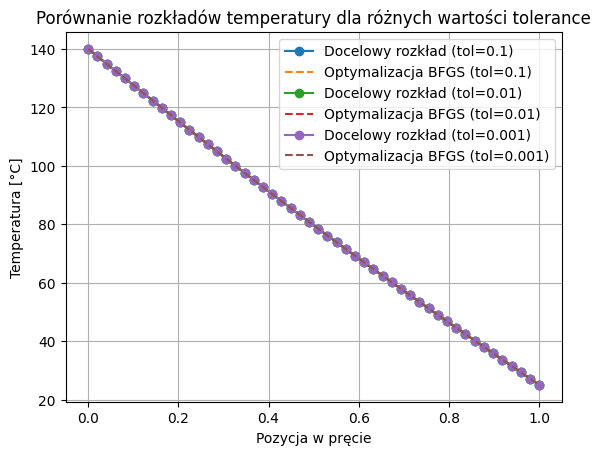

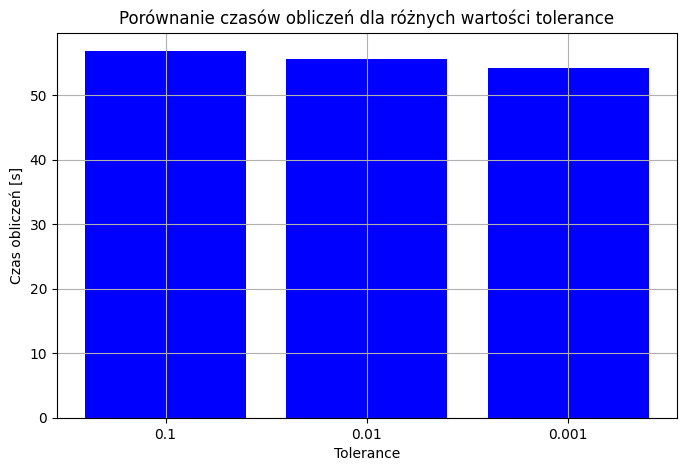

,Tolerance,Optymalne warunki brzegowe,Czas obliczeń [s],Błąd (norma L2)
0,0.100,"[140.00000000309797, 24.999999996549345]",56.871527,1.369187e-08
1,0.010,"[140.00000000309797, 24.999999996549345]",55.644226,1.369187e-08
2,0.001,"[140.00000000309797, 24.999999996549345]",54.279222,1.369187e-08


In [25]:
import time
import matplotlib.pyplot as plt

# Parametry testowe
kal = 237.0  # Przewodność cieplna aluminium (jednorodny materiał)
kw = 237.0    # Jednorodny materiał (przyjęty taki sam jak kal)
T_left = 140
T_right = 25
N = 50         # Stała liczba węzłów

# Lista wartości tolerance do analizy
tolerance_values = [1e-1, 1e-2, 1e-3]

# Przechowywanie wyników
results = []

# Testowanie dla różnych wartości tolerance
for tolerance in tolerance_values:
    # Generowanie docelowego rozkładu temperatury
    T_target = solve_temperature_1D(T_left, T_right, N, kal, kw)

    # Pomiar czasu działania metody BFGS
    start_time = time.time()
    optimal_conditions_bfgs = optimize_bfgs_1D(T_target, N, kal, kw)
    end_time = time.time()

    # Rozkład temperatury po optymalizacji
    T_optimized = solve_temperature_1D(optimal_conditions_bfgs[0], 
                                       optimal_conditions_bfgs[1], 
                                       N, kal, kw)
    
    # Obliczenie błędu (norma L2)
    error = np.linalg.norm(T_optimized - T_target, 2)

    # Przechowywanie wyników
    results.append({
        'Tolerance': tolerance,
        'Optymalne warunki brzegowe': optimal_conditions_bfgs,
        'Czas obliczeń [s]': end_time - start_time,
        'Błąd (norma L2)': error
    })

    # Wizualizacja rozkładu temperatury
    plt.plot(np.linspace(0, 1, N), T_target, '-o', label=f'Docelowy rozkład (tol={tolerance})')
    plt.plot(np.linspace(0, 1, N), T_optimized, '--', label=f'Optymalizacja BFGS (tol={tolerance})')

# Finalizacja wykresu rozkładu temperatury
plt.title('Porównanie rozkładów temperatury dla różnych wartości tolerance')
plt.xlabel('Pozycja w pręcie')
plt.ylabel('Temperatura [°C]')
plt.grid(True)
plt.legend()
plt.show()

# Tabela wyników
import pandas as pd
df_results = pd.DataFrame(results)

# Wizualizacja czasów obliczeń
plt.figure(figsize=(8, 5))
plt.bar(df_results['Tolerance'].astype(str), df_results['Czas obliczeń [s]'], color='blue')
plt.title('Porównanie czasów obliczeń dla różnych wartości tolerance')
plt.xlabel('Tolerance')
plt.ylabel('Czas obliczeń [s]')
plt.grid(True)
plt.show()

# Wyświetlenie wyników
display(df_results)


W ramach zadania przeanalizowano wpływ wartości parametru tolerance na dokładność oraz czas obliczeń w zadaniu odwrotnym. Przeprowadzono testy dla trzech wartości tolerancji: 10⁻¹, 10⁻² oraz 10⁻³, przy stałej liczbie węzłów N = 50.

Analiza wyników pokazuje, że zmiana wartości tolerancji praktycznie nie wpłynęła na dokładność rozwiązania. We wszystkich przypadkach błąd (norma L2) pozostał na identycznym poziomie, wynoszącym około 1.37 × 10⁻⁸. Uzyskane optymalne warunki brzegowe również były identyczne, co świadczy o tym, że wszystkie testowane wartości tolerance pozwoliły algorytmowi na osiągnięcie wysokiej precyzji.

Różnice pojawiły się natomiast w czasie obliczeń. Choć zmiany były stosunkowo niewielkie, zauważono, że niższe wartości tolerance prowadziły do nieznacznie krótszego czasu działania algorytmu. Dla tolerance = 0.1 obliczenia trwały około 56.9 sekundy, podczas gdy dla tolerance = 0.001 czas skrócił się do około 54.3 sekundy. Sugeruje to, że niższe wartości tolerancji pozwalają algorytmowi szybciej zakończyć pracę, ponieważ kryterium zbieżności zostaje osiągnięte wcześniej.

Podsumowując, wyniki wskazują, że w tym przypadku zmiana wartości tolerance nie wpływa na poprawę dokładności, a jedynie na minimalne skrócenie czasu działania algorytmu. Wartość tolerance = 0.01 wydaje się być optymalnym wyborem, zapewniając zarówno wysoką dokładność, jak i efektywność obliczeń.

Zadanie 3

c:\Users\msigm\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minimize.py:733: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.000000
         Iterations: 41
         Function evaluations: 260
         Gradient evaluations: 84
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 47
         Function evaluations: 255
         Gradient evaluations: 85


c:\Users\msigm\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minimize.py:733: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.000000
         Iterations: 35
         Function evaluations: 245
         Gradient evaluations: 78


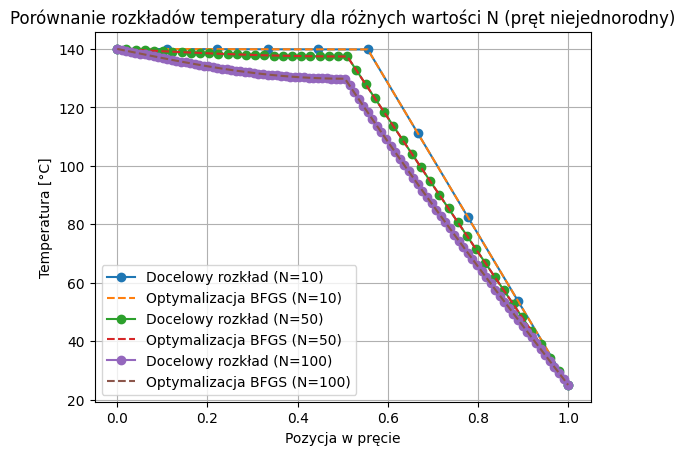

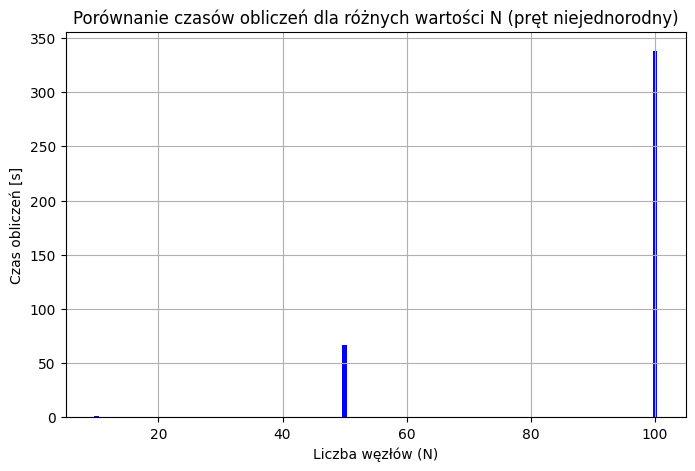

,N,Optymalne warunki brzegowe,Czas obliczeń [s],Błąd (norma L2)
0,10,"[139.9999999936902, 24.999999993699905]",1.303815,1.993823e-08
1,50,"[139.9999999930609, 24.999999995732455]",66.552944,4.421188e-08
2,100,"[139.9999999953739, 24.999999999823096]",338.382298,3.588954e-08


In [26]:
import time
import matplotlib.pyplot as plt

# Parametry testowe
kal = 237.0  # Przewodność cieplna aluminium
kw = 0.12    # Przewodność cieplna drewna
T_left = 140
T_right = 25

# Lista wartości N do analizy
N_values = [10, 50, 100]

# Przechowywanie wyników
results = []

# Testowanie dla różnych wartości N
for N in N_values:
    # Generowanie docelowego rozkładu temperatury (pręt niejednorodny)
    T_target = solve_temperature_1D(T_left, T_right, N, kal, kw)

    # Pomiar czasu działania metody BFGS
    start_time = time.time()
    optimal_conditions_bfgs = optimize_bfgs_1D(T_target, N, kal, kw)
    end_time = time.time()

    # Rozkład temperatury po optymalizacji
    T_optimized = solve_temperature_1D(optimal_conditions_bfgs[0], 
                                       optimal_conditions_bfgs[1], 
                                       N, kal, kw)
    
    # Obliczenie błędu (norma L2)
    error = np.linalg.norm(T_optimized - T_target, 2)

    # Przechowywanie wyników
    results.append({
        'N': N,
        'Optymalne warunki brzegowe': optimal_conditions_bfgs,
        'Czas obliczeń [s]': end_time - start_time,
        'Błąd (norma L2)': error
    })

    # Wizualizacja rozkładu temperatury
    plt.plot(np.linspace(0, 1, N), T_target, '-o', label=f'Docelowy rozkład (N={N})')
    plt.plot(np.linspace(0, 1, N), T_optimized, '--', label=f'Optymalizacja BFGS (N={N})')

# Finalizacja wykresu rozkładu temperatury
plt.title('Porównanie rozkładów temperatury dla różnych wartości N (pręt niejednorodny)')
plt.xlabel('Pozycja w pręcie')
plt.ylabel('Temperatura [°C]')
plt.grid(True)
plt.legend()
plt.show()

# Tabela wyników
import pandas as pd
df_results = pd.DataFrame(results)

# Wizualizacja czasów obliczeń
plt.figure(figsize=(8, 5))
plt.bar(df_results['N'], df_results['Czas obliczeń [s]'], color='blue')
plt.title('Porównanie czasów obliczeń dla różnych wartości N (pręt niejednorodny)')
plt.xlabel('Liczba węzłów (N)')
plt.ylabel('Czas obliczeń [s]')
plt.grid(True)
plt.show()

# Wyświetlenie wyników
display(df_results)


Przeprowadzona analiza miała na celu zbadanie, jak zmiana liczby węzłów (N = 10, N = 50, N = 100) wpływa na dokładność oraz czas obliczeń w zadaniu odwrotnym dla pręta niejednorodnego (50% aluminium, 50% drewno).

Wyniki pokazały, że wprowadzenie niejednorodności istotnie wpłynęło na rozkład temperatury w pręcie, co wyraźnie widać na wykresach. W przypadku pręta złożonego z dwóch materiałów pojawiło się charakterystyczne załamanie w profilu temperatury w okolicach połowy długości pręta — w miejscu przejścia z aluminium na drewno.

Pod względem dokładności zauważono, że już przy N = 10 uzyskano zadowalające wyniki. Błąd (norma L2) wyniósł 1.99 × 10⁻⁸ i pozostał na porównywalnym poziomie również dla większych wartości N. Podobnie jak w przypadku pręta jednorodnego, zwiększenie liczby węzłów nie prowadziło do znacznej poprawy dokładności — różnice były marginalne.

Różnice były natomiast bardzo widoczne w czasie obliczeń. Przy N = 10 czas działania algorytmu wyniósł zaledwie 1.3 s, natomiast dla N = 100 obliczenia trwały już ponad 338 s. Wzrost liczby węzłów znacząco zwiększył czas obliczeń, co jest efektem większej liczby punktów do przeliczenia oraz bardziej skomplikowanego rozkładu temperatury wynikającego z niejednorodności materiału.

Podsumowując, wprowadzenie niejednorodności w pręcie wyraźnie zwiększyło złożoność problemu, co przełożyło się na większy czas obliczeń. Mimo to, nawet przy niewielkiej liczbie węzłów (N = 10), uzyskano wysoką dokładność, co czyni tę konfigurację najbardziej optymalną pod względem efektywności.



Wprowadzenie niejednorodności w pręcie nie wpłynęło istotnie na dokładność wyników — niezależnie od liczby węzłów błąd pozostał na bardzo niskim poziomie. Jednakże, zwiększenie liczby węzłów w przypadku pręta niejednorodnego wiązało się z istotnym wzrostem czasu obliczeń, co pokazuje, że problem staje się bardziej wymagający obliczeniowo.

Zadanie 4

In [27]:
import time
import matplotlib.pyplot as plt

# Parametry testowe
kal = 237.0  # Przewodność cieplna aluminium
kw = 0.12    # Przewodność cieplna drewna
T_left = 75
T_right = 220
N = 50         # Stała liczba węzłów

# Przechowywanie wyników
results = []

# Generowanie docelowego rozkładu temperatury (pręt niejednorodny)
T_target = solve_temperature_1D(T_left, T_right, N, kal, kw)

# Metoda Newton-CG
start_time = time.time()
optimal_conditions_newton = optimize_newton_cg_1D(T_target, N, kal, kw)
end_time = time.time()
T_optimized_newton = solve_temperature_1D(optimal_conditions_newton[0], 
                                          optimal_conditions_newton[1], 
                                          N, kal, kw)
error_newton = np.linalg.norm(T_optimized_newton - T_target, 2)

results.append({
    'Metoda': 'Newton-CG',
    'Optymalne warunki brzegowe': optimal_conditions_newton,
    'Czas obliczeń [s]': end_time - start_time,
    'Błąd (norma L2)': error_newton
})

# Metoda Gradientu Prostego
start_time = time.time()
optimal_conditions_gd = gradient_descent_1D(T_target, N, kal, kw)
end_time = time.time()
T_optimized_gd = solve_temperature_1D(optimal_conditions_gd[0], 
                                      optimal_conditions_gd[1], 
                                      N, kal, kw)
error_gd = np.linalg.norm(T_optimized_gd - T_target, 2)

results.append({
    'Metoda': 'Gradient Prostego',
    'Optymalne warunki brzegowe': optimal_conditions_gd,
    'Czas obliczeń [s]': end_time - start_time,
    'Błąd (norma L2)': error_gd
})

# Wizualizacja rozkładu temperatury
plt.plot(np.linspace(0, 1, N), T_target, '-o', label='Docelowy rozkład temperatury')
plt.plot(np.linspace(0, 1, N), T_optimized_newton, '--', label='Optymalizacja Newton-CG')
plt.plot(np.linspace(0, 1, N), T_optimized_gd, '--', label='Optymalizacja Gradient Prostego')

plt.title('Porównanie rozkładów temperatury dla różnych metod gradientowych')
plt.xlabel('Pozycja w pręcie')
plt.ylabel('Temperatura [°C]')
plt.grid(True)
plt.legend()
plt.show()

# Tabela wyników
import pandas as pd
df_results = pd.DataFrame(results)

# Wizualizacja czasów obliczeń
plt.figure(figsize=(8, 5))
plt.bar(df_results['Metoda'], df_results['Czas obliczeń [s]'], color='blue')
plt.title('Porównanie czasów obliczeń dla metod gradientowych')
plt.xlabel('Metoda gradientowa')
plt.ylabel('Czas obliczeń [s]')
plt.grid(True)
plt.show()

# Wyświetlenie wyników
display(df_results)


c:\Users\msigm\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_optimize.py:2125: OptimizeWarning: Warning: CG iterations didn't converge. The Hessian is not positive definite.
  return terminate(3, msg)


         Current function value: 90.938485
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 86
         Hessian evaluations: 0


Gradient Descent Progress:   1%|          | 52/10000 [00:50<2:41:53,  1.02iter/s]


KeyboardInterrupt: 

Zadanie 5

In [ ]:
import numpy as np
from scipy.optimize import minimize
import time
import matplotlib.pyplot as plt

# Modyfikacja funkcji rozkładu temperatury dla zmiennego współczynnika k(x)
def solve_temperature_variable_k(T_left, T_right, N=50, k1=237.0, k2=0.12, tolerance=0.01):
    """
    Rozwiązuje jednowymiarowy problem przewodnictwa ciepła
    dla pręta niejednorodnego z różnymi współczynnikami przewodnictwa.

    Parametry:
    - T_left: temperatura na lewym brzegu pręta
    - T_right: temperatura na prawym brzegu pręta
    - N: liczba węzłów w siatce
    - k1: współczynnik przewodnictwa cieplnego (aluminium)
    - k2: współczynnik przewodnictwa cieplnego (drewno)
    - tolerance: kryterium zbieżności iteracji

    Zwraca:
    - T: rozkład temperatury w pręcie
    """
    dx = 1.0 / (N - 1)

    # Inicjalizacja temperatury
    T = np.zeros(N)
    T[0] = T_left
    T[-1] = T_right

    # Współczynniki przewodnictwa cieplnego
    k = np.ones(N) * k1
    k[N//2:] = k2  # Połowa pręta z drewna

    # Iteracyjne rozwiązywanie równania różnicowego
    for _ in range(10000):
        T_old = T.copy()
        for i in range(1, N - 1):
            T[i] = (k[i-1] * T_old[i-1] + k[i] * T_old[i+1]) / (k[i-1] + k[i])

        # Kryterium zbieżności
        if np.linalg.norm(T - T_old, np.inf) < tolerance:
            break

    return T

# Funkcja kosztu dla optymalizacji
def cost_function_k(params, T_target, N=50, T_left=220, T_right=50):
    k1, k2 = params
    T_approx = solve_temperature_variable_k(T_left, T_right, N, k1, k2)
    return np.linalg.norm(T_approx - T_target, 2)

# Optymalizacja metodą BFGS
def optimize_k_bfgs(T_target, N=50):
    initial_guess = [200.0, 0.1]  # Przybliżone wartości startowe
    result = minimize(cost_function_k, 
                      initial_guess, 
                      args=(T_target, N), 
                      method='BFGS')
    return result.x

# Parametry testowe
N = 50
T_left = 220
T_right = 50
k1_real = 237.0  # Aluminium
k2_real = 0.12   # Drewno

# Generowanie danych rozkładu temperatury
T_target = solve_temperature_variable_k(T_left, T_right, N, k1_real, k2_real)

# Optymalizacja (wyznaczenie k1 i k2)
start_time = time.time()
estimated_k1, estimated_k2 = optimize_k_bfgs(T_target, N)
end_time = time.time()

# Wizualizacja rozkładu temperatury
T_estimated = solve_temperature_variable_k(T_left, T_right, N, estimated_k1, estimated_k2)

plt.figure(figsize=(8, 5))
plt.plot(np.linspace(0, 1, N), T_target, '-o', label='Docelowy rozkład temperatury')
plt.plot(np.linspace(0, 1, N), T_estimated, '--', label='Odtworzony rozkład temperatury')
plt.title('Porównanie rozkładów temperatury (Oryginał vs Odtworzony)')
plt.xlabel('Pozycja w pręcie')
plt.ylabel('Temperatura [°C]')
plt.grid(True)
plt.legend()
plt.show()

# Wyniki
print("\n--- Wyniki ---")
print(f"Oryginalne k1: {k1_real}")
print(f"Oryginalne k2: {k2_real}")
print(f"Odtworzone k1: {estimated_k1:.4f}")
print(f"Odtworzone k2: {estimated_k2:.4f}")
print(f"Czas trwania obliczeń: {end_time - start_time:.4f} s")


Zadanie 6